In [126]:
import warnings
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.formula.api import logit
from scipy.stats import norm
from sklearn.model_selection import train_test_split
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from pandas.core.common import SettingWithCopyWarning
import sklearn 

warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)

In [106]:
#read stock data csv and set the date as the index
data = pd.read_csv("\\Users\\d117698\\Desktop\\Stock Data\\Sector_Indices_Normalized.csv", parse_dates=['date'],infer_datetime_format=True,index_col='date')

In [107]:
#drop any null columns and explore the data
data.dropna(how='all', axis=1, inplace=True)
print(data.info())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1259 entries, 2019-04-17 to 2024-04-17
Data columns (total 19 columns):
 #   Column                                                              Non-Null Count  Dtype  
---  ------                                                              --------------  -----  
 0   S&P 500 Health Care (Sector)                                        1259 non-null   float64
 1   S&P 500 Real Estate (Sector)                                        1259 non-null   float64
 2   S&P 500 Industrials (Sector)                                        1259 non-null   float64
 3   S&P 500 Information Technology (Sector)                             1259 non-null   float64
 4   S&P 500 Materials (Sector)                                          1259 non-null   float64
 5   S&P GSCI Unleaded Gasoline TR                                       1259 non-null   float64
 6   S&P GSCI Industrial Metals TR                                       1259 non-null   float64
 7

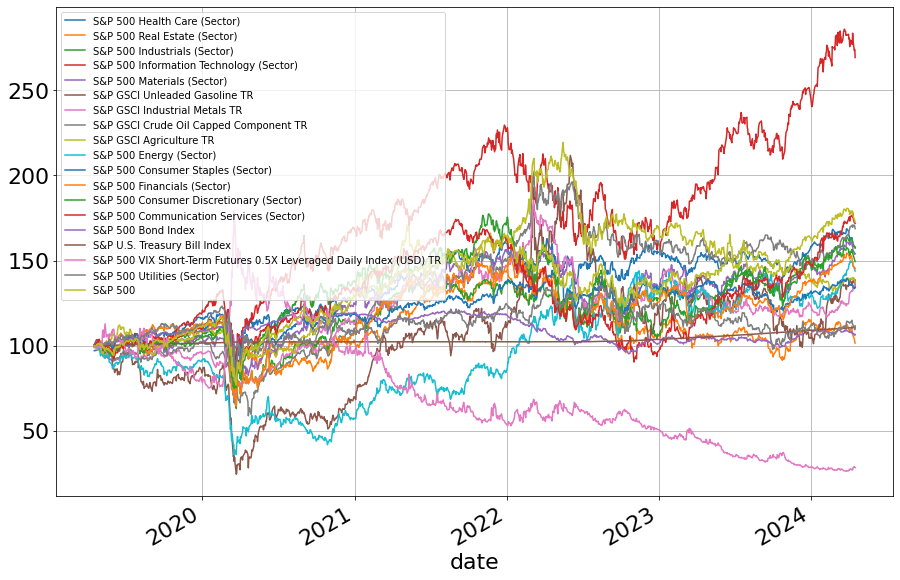

In [124]:
#plot the 5 year normalized performance
data.plot(figsize=(15,10),grid=True)
plt.legend(loc=2, prop={'size': 10})
plt.show()

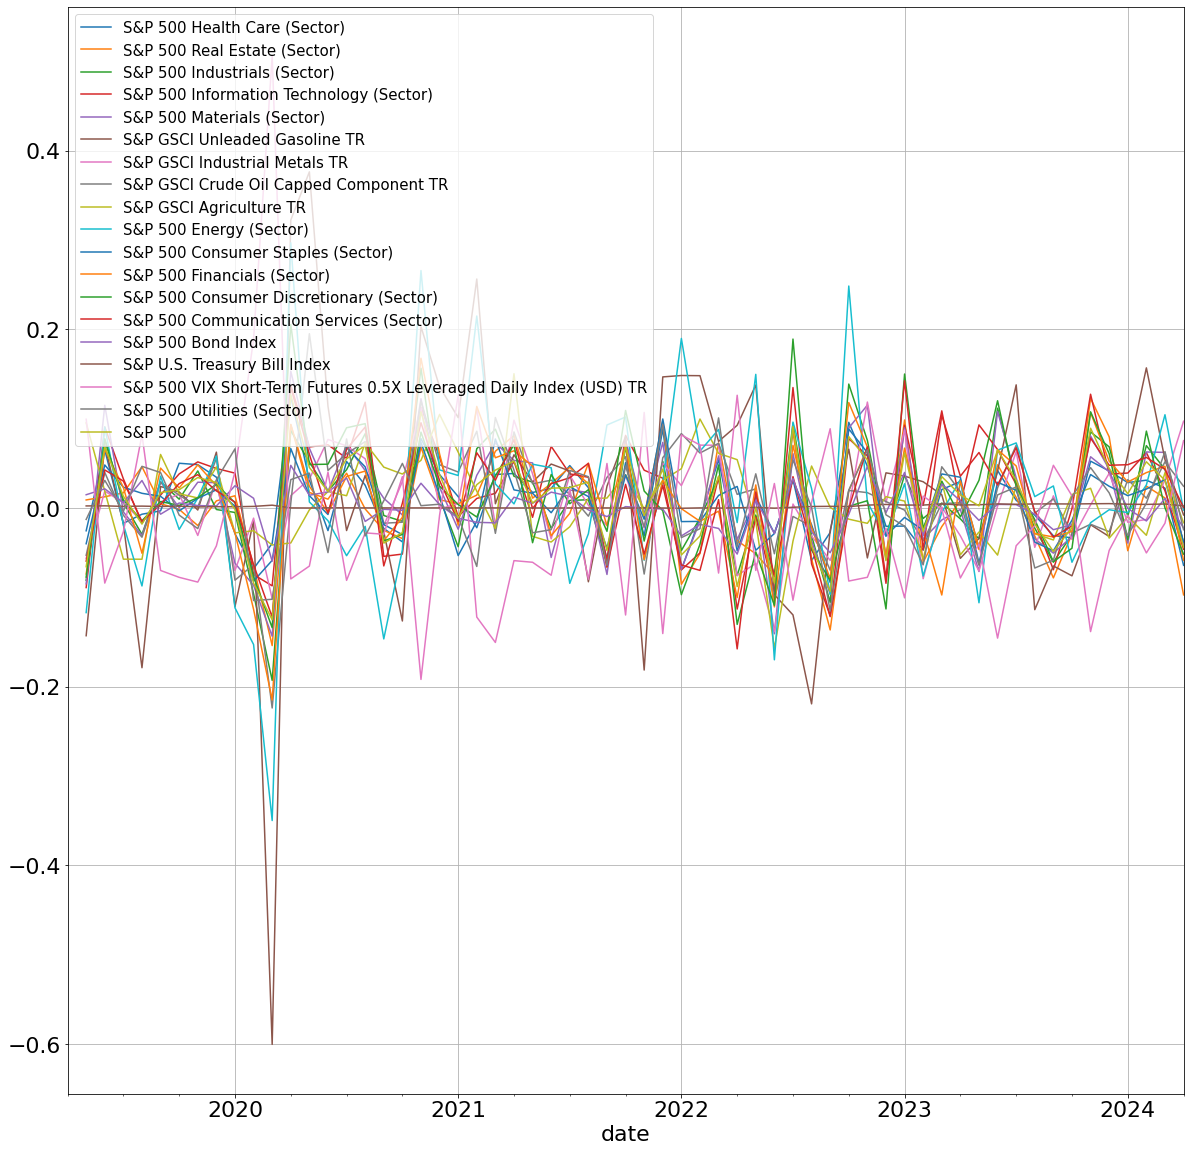

In [121]:
# Calculate Month-end prices 
Monthly_prices = data.resample('M').last()

# Calculate monthly returns 
monthly_returns = Monthly_prices.pct_change()
# Chart monthly returns
monthly_returns.plot(figsize=(20,20),grid=True)
plt.legend(loc=2, prop={'size': 15})
plt.show()

                                                    S&P 500 Health Care (Sector)  \
S&P 500 Health Care (Sector)                                            1.000000   
S&P 500 Real Estate (Sector)                                            0.711428   
S&P 500 Industrials (Sector)                                            0.748302   
S&P 500 Information Technology (Sector)                                 0.693496   
S&P 500 Materials (Sector)                                              0.780838   
S&P GSCI Unleaded Gasoline TR                                           0.401805   
S&P GSCI Industrial Metals TR                                           0.344487   
S&P GSCI Crude Oil Capped Component TR                                  0.395256   
S&P GSCI Agriculture TR                                                 0.078552   
S&P 500 Energy (Sector)                                                 0.484410   
S&P 500 Consumer Staples (Sector)                                       0.78

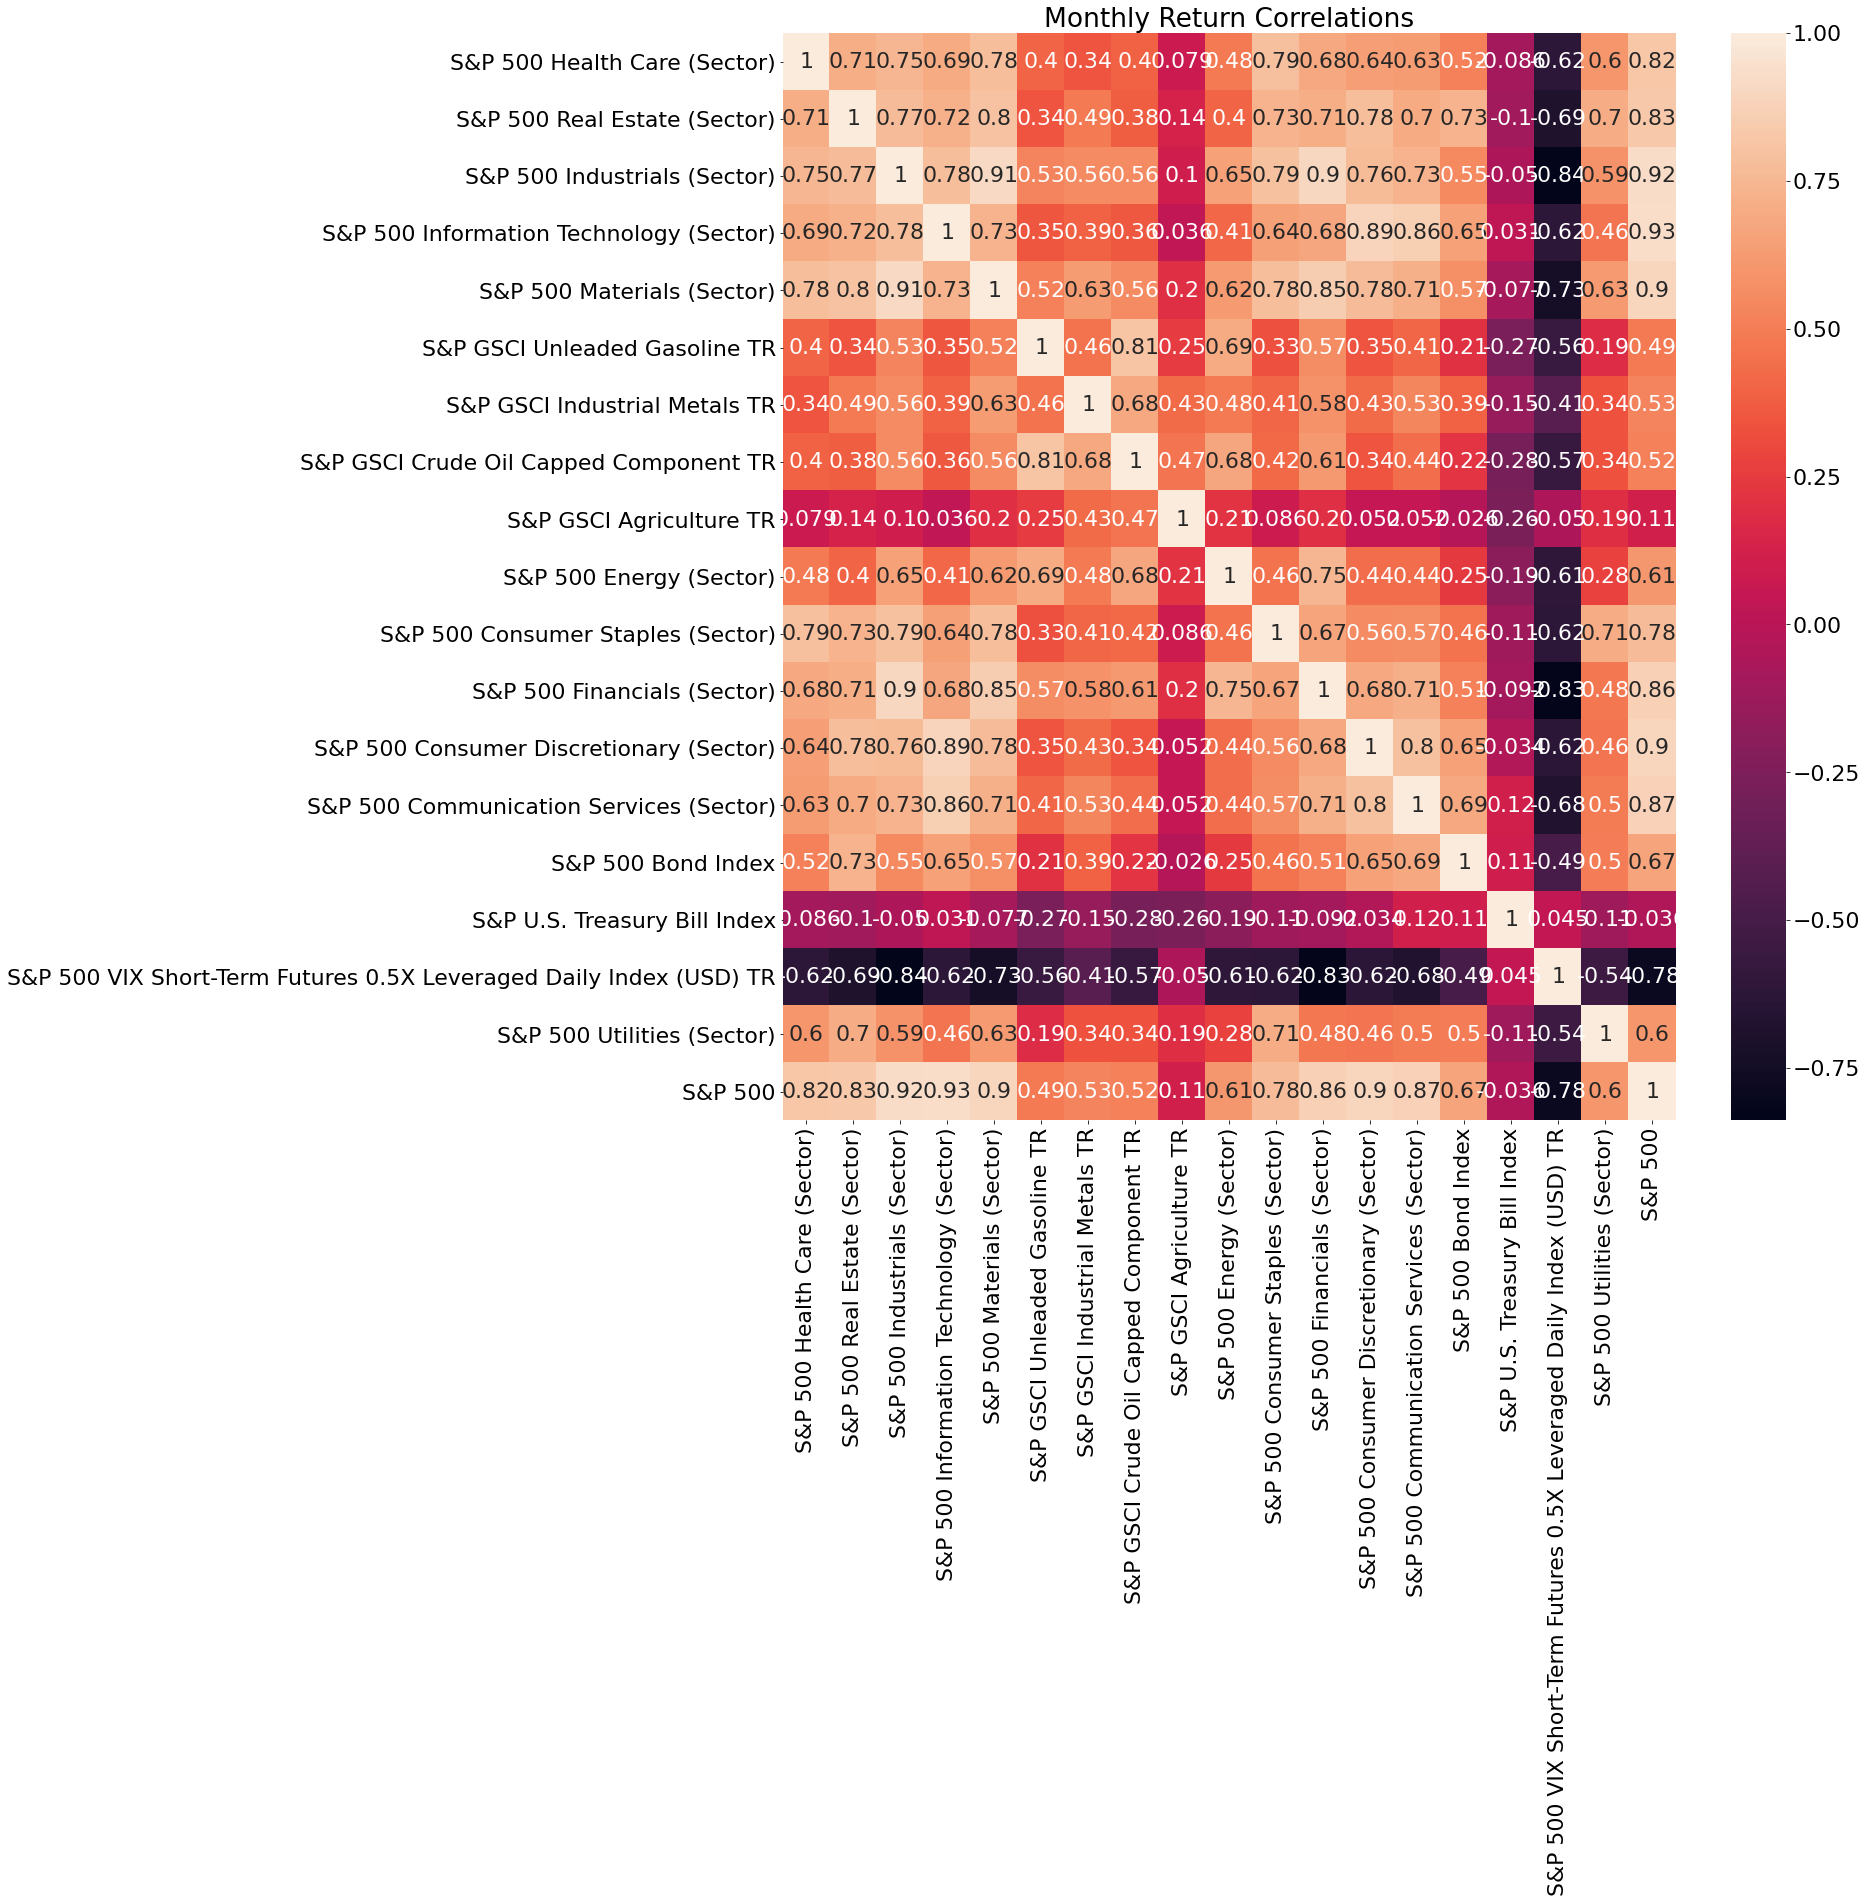

In [122]:
# Calculate and print the correlation matrix here
correlations = monthly_returns.corr()
print(correlations)

# Visualize the correlations as heatmap here
plt.figure(figsize=(20, 20))
sns.heatmap(correlations, annot=True)
plt.title('Monthly Return Correlations')
plt.show()

In [111]:
print(monthly_returns.info())
print(monthly_returns.head())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 61 entries, 2019-04-30 to 2024-04-30
Freq: M
Data columns (total 19 columns):
 #   Column                                                              Non-Null Count  Dtype  
---  ------                                                              --------------  -----  
 0   S&P 500 Health Care (Sector)                                        60 non-null     float64
 1   S&P 500 Real Estate (Sector)                                        60 non-null     float64
 2   S&P 500 Industrials (Sector)                                        60 non-null     float64
 3   S&P 500 Information Technology (Sector)                             60 non-null     float64
 4   S&P 500 Materials (Sector)                                          60 non-null     float64
 5   S&P GSCI Unleaded Gasoline TR                                       60 non-null     float64
 6   S&P GSCI Industrial Metals TR                                       60 non-null     floa

In [112]:
# Calculate and print the correlation matrix here
next_monthly_returns=monthly_returns.shift(-1)
correlations2 = monthly_returns.corrwith(next_monthly_returns)
print(correlations2)

# it doesn't look like there is much correlation between one month's returns and the next. 

S&P 500 Health Care (Sector)                                         -0.134073
S&P 500 Real Estate (Sector)                                         -0.110980
S&P 500 Industrials (Sector)                                         -0.079641
S&P 500 Information Technology (Sector)                              -0.091655
S&P 500 Materials (Sector)                                           -0.165963
S&P GSCI Unleaded Gasoline TR                                         0.057032
S&P GSCI Industrial Metals TR                                         0.081014
S&P GSCI Crude Oil Capped Component TR                                0.172783
S&P GSCI Agriculture TR                                               0.241258
S&P 500 Energy (Sector)                                              -0.129087
S&P 500 Consumer Staples (Sector)                                    -0.077751
S&P 500 Financials (Sector)                                          -0.043506
S&P 500 Consumer Discretionary (Sector)             

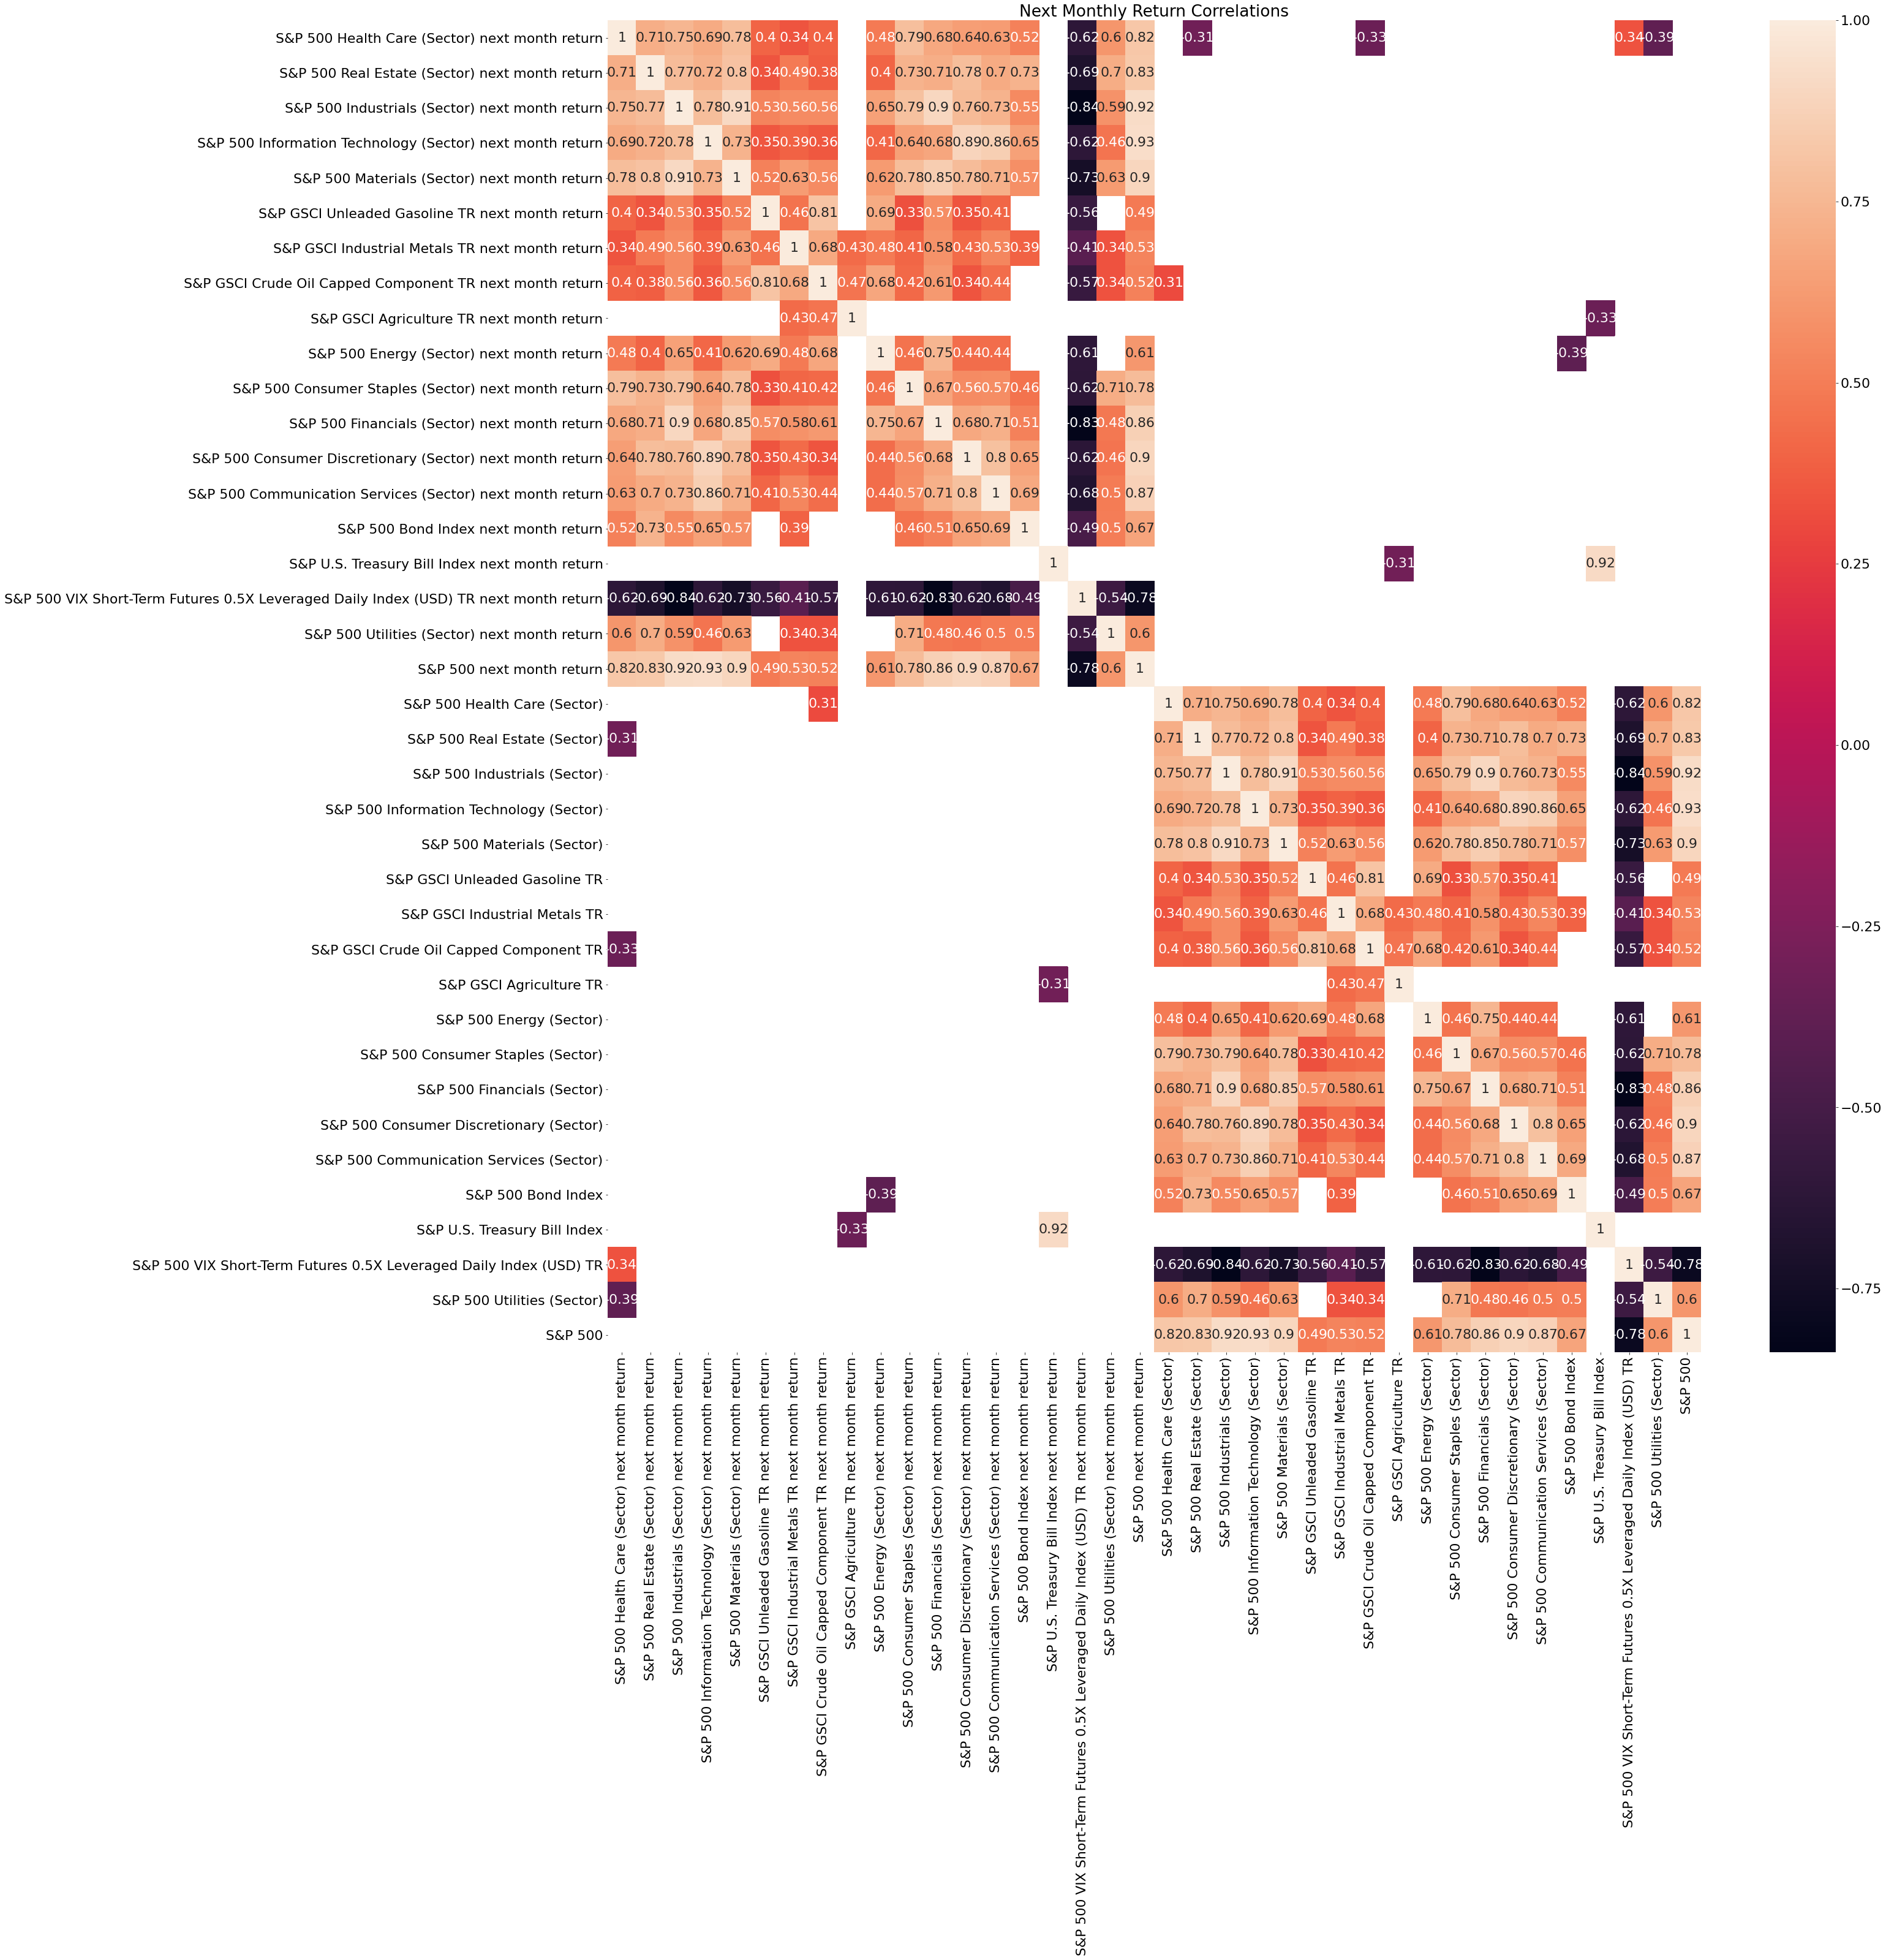

In [113]:
# Find next month's return and rename the columns accordingly. Then Join the data frames back together.
my_list=list(next_monthly_returns.columns)
string=' next month return'
my_new_list = [x + string for x in my_list]
res = {my_list[i]: my_new_list[i] for i in range(len(my_list))}
next_monthly_returns.rename(columns=res, inplace=True)
next_monthly_returns = next_monthly_returns.join(monthly_returns)

# Visualize the correlations as heatmap here

correlations3 = next_monthly_returns.corr()
correlations3 = correlations3[abs(correlations3)>=.3]

plt.figure(figsize=(40, 40))
sns.heatmap(correlations3, annot=True)
plt.title('Next Monthly Return Correlations')
plt.show()

# Again, there doesn't seem to be a strong correlation at all. 

In [128]:
#Let's focus in on the most positively correlated asset classes we can find though.(vix and next month's healthcare stock performance)

monthly_up=monthly_returns[['S&P 500 Health Care (Sector)']].applymap(lambda x: x>0)
monthly_up=monthly_up.astype(int).shift(-1)
monthly_up.rename(columns={'S&P 500 Health Care (Sector)':'health_care_increase'}, inplace=True)
monthly_up=monthly_up.join(monthly_returns[['S&P 500 VIX Short-Term Futures 0.5X Leveraged Daily Index (USD) TR']])
monthly_up.rename(columns={'S&P 500 VIX Short-Term Futures 0.5X Leveraged Daily Index (USD) TR':'vix_return'}, inplace=True)
monthly_up.drop(monthly_up.tail(1).index,inplace=True)
monthly_up.drop(monthly_up.head(1).index,inplace=True)
print(monthly_up)

            health_care_increase  vix_return
date                                        
2019-05-31                   1.0    0.099318
2019-06-30                   0.0   -0.084048
2019-07-31                   0.0   -0.026602
2019-08-31                   0.0    0.081986
2019-09-30                   1.0   -0.069908
2019-10-31                   1.0   -0.077604
2019-11-30                   1.0   -0.082920
2019-12-31                   0.0   -0.042443
2020-01-31                   0.0    0.040683
2020-02-29                   0.0    0.188827
2020-03-31                   1.0    0.505734
2020-04-30                   1.0   -0.079401
2020-05-31                   0.0   -0.065017
2020-06-30                   1.0    0.040172
2020-07-31                   1.0   -0.081006
2020-08-31                   0.0   -0.027853
2020-09-30                   0.0   -0.029409
2020-10-31                   1.0    0.035076
2020-11-30                   1.0   -0.191830
2020-12-31                   1.0   -0.008095
2021-01-31

Text(0, 0.5, 'health care increases')

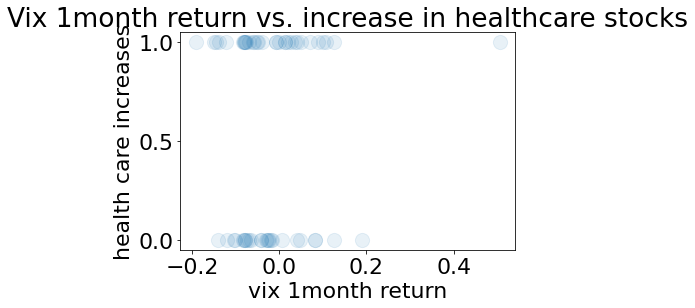

In [129]:
df=monthly_up
plt.scatter(df['vix_return'], df['health_care_increase'],alpha =0.1, s=200)
plt.title('Vix 1month return vs. increase in healthcare stocks')
plt.xlabel('vix 1month return')
plt.ylabel('health care increases')

In [130]:
df_train, df_test = train_test_split(df, test_size=0.3)

In [131]:
df_train.describe()

,health_care_increase,vix_return
count,41.000000,41.000000
mean,0.585366,-0.015261
std,0.498779,0.116362
min,0.000000,-0.191830
25%,0.000000,-0.081762
50%,1.000000,-0.026602
75%,1.000000,0.035076
max,1.000000,0.505734


In [132]:
formula="health_care_increase ~ vix_return"
est = logit(formula=formula, data=df_train).fit()
# print the results of the model (est).
# Examine; Pseudo R-squared, p values, coefficients 
print(est.summary())

Optimization terminated successfully.
         Current function value: 0.665213
         Iterations 5
                            Logit Regression Results                            
Dep. Variable:     health_care_increase   No. Observations:                   41
Model:                            Logit   Df Residuals:                       39
Method:                             MLE   Df Model:                            1
Date:                  Fri, 19 Apr 2024   Pseudo R-squ.:                 0.01958
Time:                          14:56:06   Log-Likelihood:                -27.274
converged:                         True   LL-Null:                       -27.819
Covariance Type:              nonrobust   LLR p-value:                    0.2966
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.4104      0.333      1.234      0.217      -0.241       1.062
vix_return   

In [133]:
preds = est.predict(df_test)
df_test['predicted_probability'] = preds
df_test.head(6)

,health_care_increase,vix_return,predicted_probability
date,,,
2020-08-31,0.0,-0.027853,0.579580
2019-08-31,0.0,0.081986,0.662305
2023-07-31,0.0,-0.042250,0.568281
2023-05-31,1.0,-0.040262,0.569845
2021-04-30,1.0,-0.058911,0.555116
2020-01-31,0.0,0.040683,0.632049


In [134]:
df_test['will_increase_next_month'] = np.where(df_test['predicted_probability']>0.25, 1, 0)

print(df_test)

            health_care_increase  vix_return  predicted_probability  \
date                                                                  
2020-08-31                   0.0   -0.027853               0.579580   
2019-08-31                   0.0    0.081986               0.662305   
2023-07-31                   0.0   -0.042250               0.568281   
2023-05-31                   1.0   -0.040262               0.569845   
2021-04-30                   1.0   -0.058911               0.555116   
2020-01-31                   0.0    0.040683               0.632049   
2020-09-30                   0.0   -0.029409               0.578362   
2021-05-31                   1.0   -0.060746               0.553661   
2022-03-31                   0.0   -0.072817               0.544069   
2020-07-31                   1.0   -0.081006               0.537542   
2023-12-31                   1.0   -0.047524               0.564123   
2021-06-30                   1.0   -0.075243               0.542136   
2021-1

In [136]:
y_true = df_test['health_care_increase']
y_pred = df_test['will_increase_next_month']
matrix = confusion_matrix(y_true,y_pred,labels = None)
print(matrix)

[[0 9]
 [0 9]]


<AxesSubplot:>

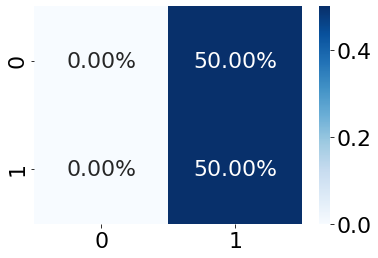

In [137]:
sns.heatmap(matrix/np.sum(matrix), annot=True, 
            fmt='.2%', cmap='Blues')

<AxesSubplot:>

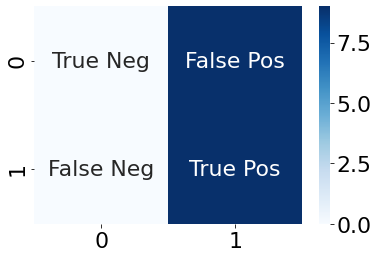

In [138]:
labels = ["True Neg","False Pos","False Neg","True Pos"]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(matrix, annot=labels, fmt="", cmap='Blues')

In [141]:
print('Accuracy:'+str(accuracy_score(df_test['health_care_increase'], df_test['will_increase_next_month'])))

Accuracy:0.5


In [ ]:
#Yikes, so our accuracy is 50/50. I think maybe, I should search for data with a better correlation.